# Задача динамического рассеяния света (DLS)

В DLS, PSD можно перевернуть от нормализованного ACF электрического поля
$$
g(\tau) = \int_{0}^{\infty} G(\Gamma)\exp(-\Gamma\tau)d\Gamma    (1)
$$
в котором G-ширина линии распада, τ-время задержки, а $G(\Gamma)$- нормализованная функция распределения линии распада. $G(\Gamma)$ содержит информацию PSD и удовлетворяет условиям $\int_{0}^{\infty}G(\Gamma)d\Gamma = 1$. Согласно следующим трем формулам, PSD может быть решена из некорректного уравнения (1).

$$
\Gamma = Dq^2 
$$

$$
q = \frac{4\pi l}{\lambda}\sin(\frac{\theta}{2})
$$

$$
D = \frac{kbT}{3\pi\eta d}
$$

в котором q-рассеянный вектор, D-коэффициент диффузии, l-длина волны падающего света в вакуум, q-угол рассеяния, l-показатель преломления раствора, T-абсолютная температура, kb - постоянная Больцмана, d-диаметр частицы, а $\eta$ -вязкость раствора

Решение задачи динамического рассеяния света (DLS) позволяет определять размеры частиц в растворе по спектру интенсивности рассеяного света. Если растворе представлен один сорт частиц, то спектр итенсивности для нее определяется кривой Лоренца:
$$
I(f) = \frac{A}{\pi} \frac{\Gamma}{(2\pi f)^2 + \Gamma^2}
$$
Здесь $f$ - частота, $\Gamma$ - характеристика частицы, обратно пропорциональная ее диаметру.

Для раствора, содержащего $n$ частиц, спектр интенсивности есть сумма Лоренцов для каждой отдельной частицы, взятых с определенным весом, пропорциональным их концентрации:
$$
I(f) = \frac{1}{\pi} \sum_{i=1}^n\frac{A(\Gamma_i)\Gamma_i}{(2\pi f)^2 + \Gamma_i^2}
$$

В результате эксперимента методом DLS получается кривая интенсивности рассеяния, по которой необходимо определить частицы каких размеров представлены в растворе. Предполагая, что 

In [1]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as sklm
import scipy
from numpy.fft import fft, fftfreq

#fft Вычислить одномерное дискретное преобразование Фурье.
#fftreq Верните дискретные частоты выборки преобразования Фурье.
# основные константы. В этой части определяется все, что связано с постановкой эксперимента
kb = 1.38064e-23 # постоянная Больцмана
T = 273.15 + 24.85 # температура в K
theta = np.pi/2 # угол рассеяния
n = 1.3331 # показатель преломления
eta = 0.89e-3 # Н * с/м^2 - динамическая вязкость воды
l = 632.8e-9 # Длина волны лазера

# далее задаем коэффициент, связывающий характеричтику Gamma с размером частицы
coeff = (kb * T/(3 * np.pi * eta)) * (4 * np.pi * n / l)**2 * np.sin(theta/2)**2
d1 = 300e-9
G1 = coeff / d1 # Gamma для частицы размером 300 нм
d2 = 700e-9
G2 = coeff / d2

# определяем кривые Лоренца для частиц
w = np.arange(1,10001)
y1 = G1 / ((2 * np.pi * w)**2 + G1**2)
y2 = G2 / ((2 * np.pi * w)**2 + G2**2)
y = y1 + y2
#y = y1



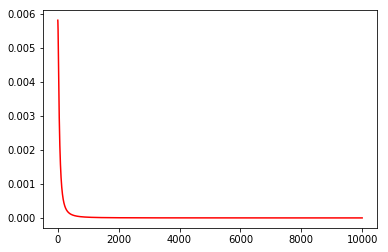

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

# кривая Лоренца
plt.plot(w, y, 'red')

# Преобразование Фурье получит Лоренц

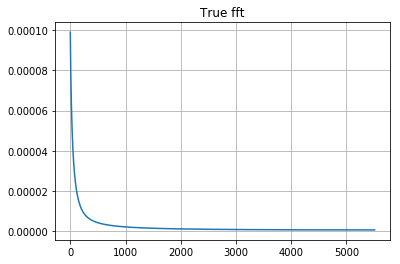

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

#fig = plt.figure(figsize=[14,4])
N = 10000           # Number of samplepoints
Fs = 11025.0
T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
#N_fft = 80        # Number of bins (chooses granularity)
x = np.linspace(0, N* T, N)     # the interval
y = y1 + y2   # the signal


# Compute the fft.
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
yf = scipy.fftpack.fft(y)


##### Plot the fft #####
plt.figure(1)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title("True fft")
plt.show()
#plt.figure(2)
#plt.plot(x, y, label = " f(x)")
#plt.show()

In [4]:
# диапазон размеров частиц, где ищем нужный размер 
d_min = 1e-9 # 1 нм
d_max = 1e-6 

# задаем сетку по Gamma
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8 # Число узлов в сетке по \Gamma
M = w.size # Число точек по частоте
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# неравнмерная сетка со сгущением к нулю (так как больщий вклад в интенсивность дают крупные частицы)
# хотя такая сетка - это не единственно возможный вариант
for j in range(N):
    G[j] = G_min * (p**j)

# вот равномерная сетка
#G = np.linspace(G_min, G_max, N)    

A = np.zeros((M,N))

# Матрица коэффициентов (составляется по базисным ф-ям)
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * w[i])**2 + G[j]**2)  

In [20]:
# Функция для построения для одного примера
import scipy.signal

import scipy.stats as stats

def draw_given(w, d1, d2, i, y, y1 = [], y2 = []):
    fig = plt.figure()
    ax1 = plt.subplot(N_samples,2,2*i+1)
    
    if (len(y1) != 0): 
        plt.plot(w, y1, 'darkblue')
    if (len(y2) != 0): 
        plt.plot(w, y2, 'blue')
    
    plt.plot(w, y, 'red')
    #Вывод уже умножив на 1e+9
    ax1.set_title('Peaks given: [{0:.0f}  {1:.0f}]'.format(d1 * 1e+9, d2 * 1e+9)) # {0:2.0e}
    ax1.set_xlabel('Frequency')
    
def draw_found(w, i, y):
    #Tixanova
    clf = sklm.Ridge(alpha = 5e-7)
    #clf.fit(A, y)
#    a = clf.coef_
#     Cumulant
#    a = stats.kstatvar(A, 2)
#     a = clf.coef_
#     ## BayesianRidge
#     clf = sklm.BayesianRidge()
#     clf.fit(A,y)
#     a = clf.coef_
    
    ax2 = plt.subplot(N_samples,2,2*i+2)
    line, = plt.plot(1e+9 * coeff/G, a,'.-')
    ax2.set_xscale('log')
    plt.xlim(d_min*1e9, d_max*1e9)
    ax2.set_xlabel('Diameter, *10e-9')
    
    indexes, _ = scipy.signal.find_peaks(a, height=0.002, distance=10) #height нужно задавать правильный
    peaks = sorted(1e+9*coeff/G[indexes])
    if (len(peaks) == 2):
        ax2.set_title('Peaks found: [{0:.0f}   {1:.0f}]'.format(peaks[0], peaks[1])) # 'Peaks found: %s' % (1e+9*coeff/G[indexes])
    elif (len(peaks) == 3):
        ax2.set_title('Peaks found: [{0:.0f}   {1:.0f}   {2:.0f}]'.format(peaks[0], peaks[1], peaks[2]))
    else:
        ax2.set_title('Peak found: [{0:.0f}]'.format(peaks[0]))

ValueError: x and y must have same first dimension, but have shapes (2048,) and (1,)

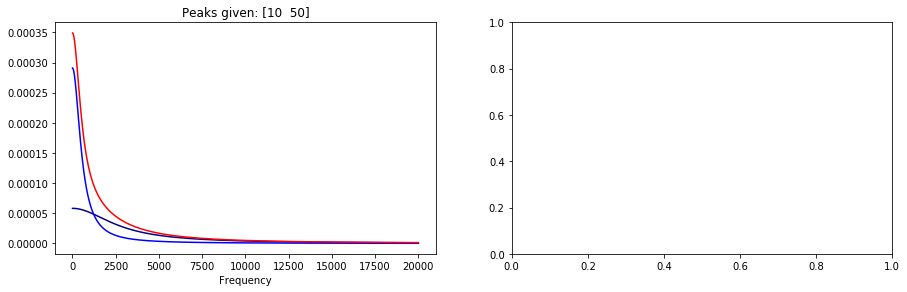

In [21]:
# Set samples
N_samples = 8

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 #width
fig_size[1] = 5 * N_samples #height
plt.rcParams["figure.figsize"] = fig_size

d1_mass = [10, 10, 50, 100, 100, 200, 400, 400] 
d1_mass = [sample * 1e-9 for sample in d1_mass]

d2_mass = [50, 100, 500, 200, 400, 600, 500, 800]
d2_mass = [sample * 1e-9 for sample in d2_mass]

G1_mass = coeff / d1_mass
G2_mass = coeff / d2_mass

w = 2.0*np.arange(1,10001)
y_mass = np.zeros((N_samples, w.size))

for i in range(N_samples):
    y1 = G1_mass[i] / ((2 * np.pi * w)**2 + G1_mass[i]**2)
    y2 = G2_mass[i] / ((2 * np.pi * w)**2 + G2_mass[i]**2)
    y_mass[i,:] = y1 + y2

    draw_given(w, d1_mass[i], d2_mass[i], i, y_mass[i,:], y1, y2)
    draw_found(w, i, y_mass[i,:])

In [ ]:
# BayesianRidge
clf = sklm.BayesianRidge()
clf.fit(A,y)
a1 = clf.coef_
#ax = plt.subplot(num_of_methods,1,num)
ax = plt.subplot(3,1,1)
line, = plt.plot(1e+9 * coeff/G, a1,'.-')
ax.set_xscale('log')
plt.xlim(d_min*1e9, d_max*1e9)

In [ ]:
# определяем размер частицы, для которой получился максимальный коэффициент
import scipy.signal
indexes, _ = scipy.signal.find_peaks(a2, height=0.02, distance=50)
print('Peaks are: %s' % (1e+9*coeff/G[indexes]))
# i, = np.where( a2==max(a2) )
# print('Particle size = ', 1e+9*coeff/G[i])